In [13]:
"""
- 사용 데이터: office_data_merged.parquet
- 출력 파일: X_lstm.npy, y_lstm.npy ([value, meter_type])
- 시각화 포함
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import joblib
import sys
import os

# print(os.getcwd())

script_path = os.path.abspath("../scripts")
if script_path not in sys.path:
    sys.path.append(script_path)

# print(script_path)
from utils import (
    meter_name_to_id,
    meter_id_to_name,
    decode_meter_type,
    inverse_transform
)

# 설정
INPUT_PATH = "../data/processed/office_data_merged.parquet"
OUTPUT_DIR = Path("../data/processed")
SCALER_DIR = Path("models")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
SCALER_DIR.mkdir(parents=True, exist_ok=True)
# X_OUTPUT = os.path.join(OUTPUT_DIR, "X_lstm.npy")
# Y_OUTPUT = os.path.join(OUTPUT_DIR, "y_lstm.npy")
# SCALER_OUTPUT = Path("models/standard_scaler.pkl")

In [14]:
# 데이터 불러오기
df_all = pd.read_parquet(INPUT_PATH)
print("Original shape:", df_all.shape)

# # meter_type 디코딩
# df["meter_type"] = df["meter_type"].apply(decode_meter_type)

# 조건 필터링 (예시)
# df_all = df_all[
    # (df["meter_type"]  "electricity") 
    # (df_all["source"]  "ASHRAE") 
    # & (df_all["building_id"]  "Hog_office_Cornell")
# ].copy()
# print("After filtering:", df_all.shape)

Original shape: (14665244, 21)


In [15]:
# 입력 및 타겟 변수 설정
input_cols = [
    "air_temperature", "dew_temperature", "sea_level_pressure", "wind_direction",
    "wind_speed", "cloud_coverage", "square_feet", "hour", "dayofweek",
    "is_weekend", "holiday", "meter_type", "value"
]
target_cols = ["value", "air_temperature"]  # occupancy는 나중에 추가 예정
meter_types = ["electricity","chilledwater", "steam" , "hotwater", "gas", "water", "irrigation", "solar"]
# meter_type_mapping = {
#    "electricity": 0,
#    "chilledwater": 1,
#    "steam": 2,
#    "hotwater": 3,
#    "gas": 4,
#    "water": 5,
#    "irrigation": 6,
#    "solar": 7
# }

window_size = 24
chunk_size = 100000  # 슬라이딩 윈도우 처리 시 한 번에 처리할 row 수


In [16]:

# 결측치 제거 및 정렬
# df_all = df_all.dropna(subset=input_cols + target_cols)
# df_all = df_all.sort_values("timestamp")

df_chuck = df_all.dropna(subset=input_cols + target_cols).sort_values("timestamp").sample(n=chunk_size, random_state=42)
df_chuck["meter_type"] = df_chuck["meter_type"].apply(decode_meter_type)
df_chuck["meter_type"] = df_chuck["meter_type"].map(meter_name_to_id)

print("After dropna & sort:", df_all.shape)

After dropna & sort: (14665244, 21)


In [17]:
scaler_X = StandardScaler().fit(df_chuck[input_cols].values)
scaler_y = StandardScaler().fit(df_chuck[target_cols].values)

joblib.dump(scaler_X, SCALER_DIR / "scaler_X_all.pkl")
joblib.dump(scaler_y, SCALER_DIR / "scaler_y_all.pkl")

['models/scaler_y_all.pkl']

In [18]:
# # meter_type별 슬라이딩 윈도우 변환 및 저장 
# for meter in meter_types:
#    print(f"Processing meter_type: {meter}")

#    df = df_all.copy()
#    df["meter_type"] = df["meter_type"].apply(decode_meter_type)
#    df = df[df["meter_type"]  meter].copy()

#    if df.empty:
#        print(f"No data for meter_type={meter}, skipping.")
#        continue

#    df = df.dropna(subset=input_cols + target_cols)
#    df = df.sort_values("timestamp")
#    df["meter_type"] = df["meter_type"].map(meter_name_to_id)

#    df_X = df[input_cols].values  # ndarray
#    df_y = df[target_cols].values

#    X_path = OUTPUT_DIR / f"X_lstm_{meter}.npy"
#    y_path = OUTPUT_DIR / f"y_lstm_{meter}.npy"

#    # memmap으로 저장 공간 미리 확보
#    n_seq_estimate = len(df) - window_size
#    X_memmap = np.lib.format.open_memmap(X_path, dtype='float32', mode='w+', shape=(n_seq_estimate, window_size, len(input_cols)))
#    y_memmap = np.lib.format.open_memmap(y_path, dtype='float32', mode='w+', shape=(n_seq_estimate, len(target_cols)))

#    valid_idx = 0
#    X_batch, y_batch = [], []

#    for i in range(n_seq_estimate):
#        X_window = df_X[i:i+window_size]
#        y_target = df_y[i+window_size]
#        X_batch.append(X_window)
#        y_batch.append(y_target)

#    # transform batch
#    X_batch = np.array(X_batch)
#    y_batch = np.array(y_batch)
#    X_scaled = scaler_X.transform(X_batch.reshape(-1, len(input_cols))).reshape(-1, window_size, len(input_cols))
#    y_scaled = scaler_y.transform(y_batch)

#    # write to disk
#    X_memmap[:len(X_scaled)] = X_scaled
#    y_memmap[:len(y_scaled)] = y_scaled
#    valid_idx = len(X_scaled)

#    print(f"Saved {valid_idx} sequences for {meter} to {X_path.name} and {y_path.name}")



 시각화: electricity


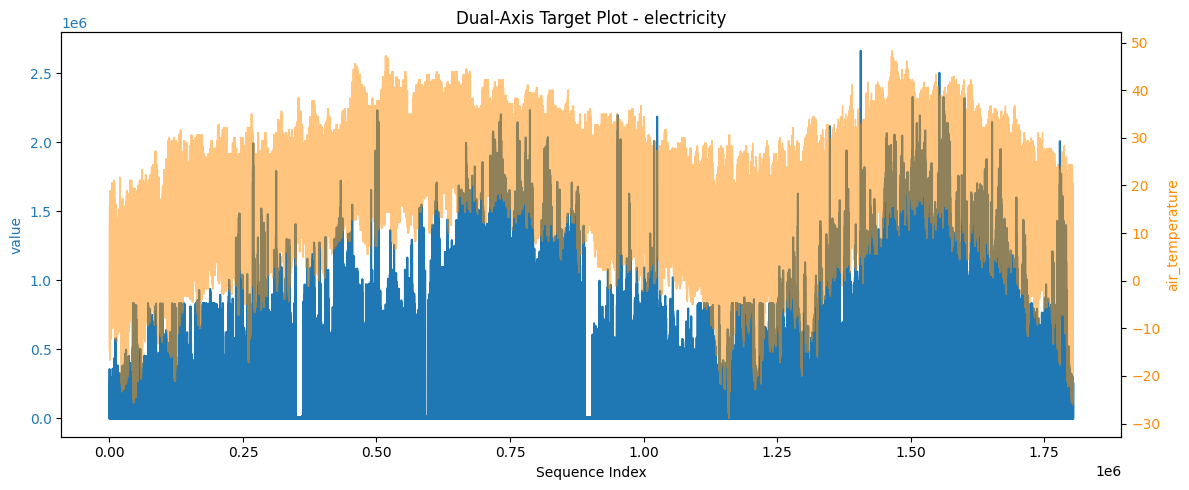

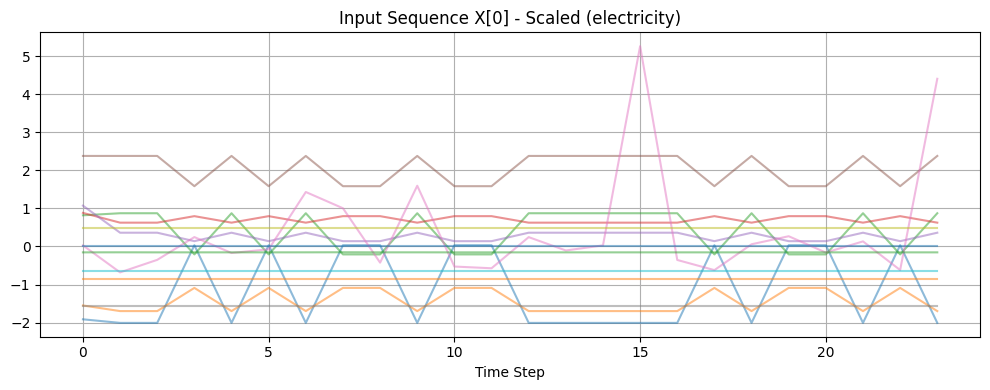

정규화된 y[0]: [-0.1536806   0.03314328]
복원된 y[0] (value, air_temperature): [46.247025 15.6     ]

 시각화: chilledwater


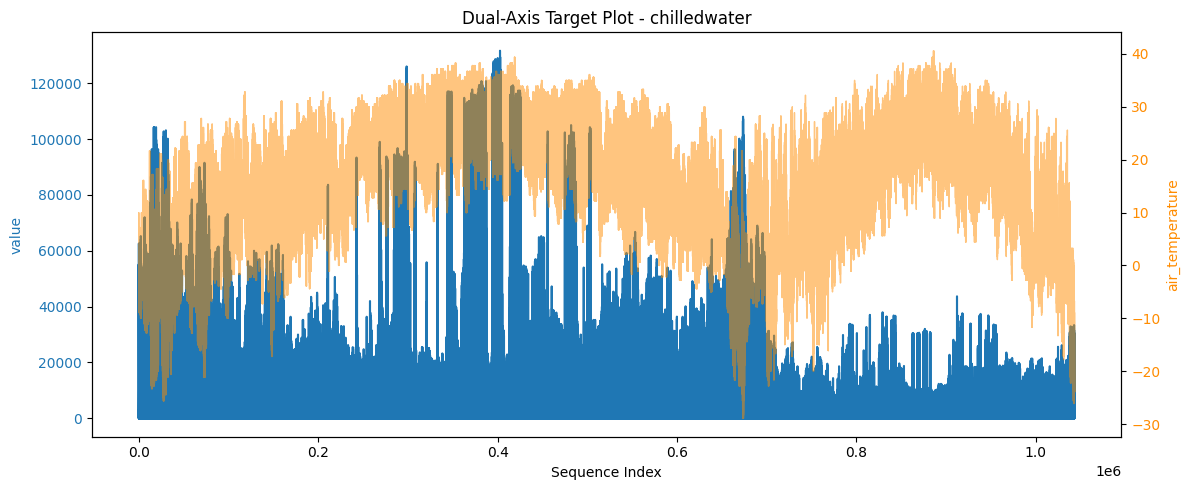

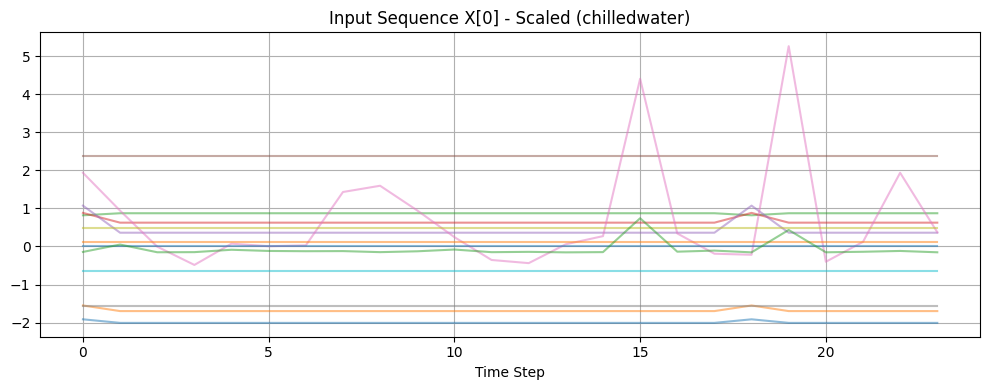

정규화된 y[0]: [-0.11127525 -2.0086198 ]
복원된 y[0] (value, air_temperature): [2757.81       -8.300002]

 시각화: steam


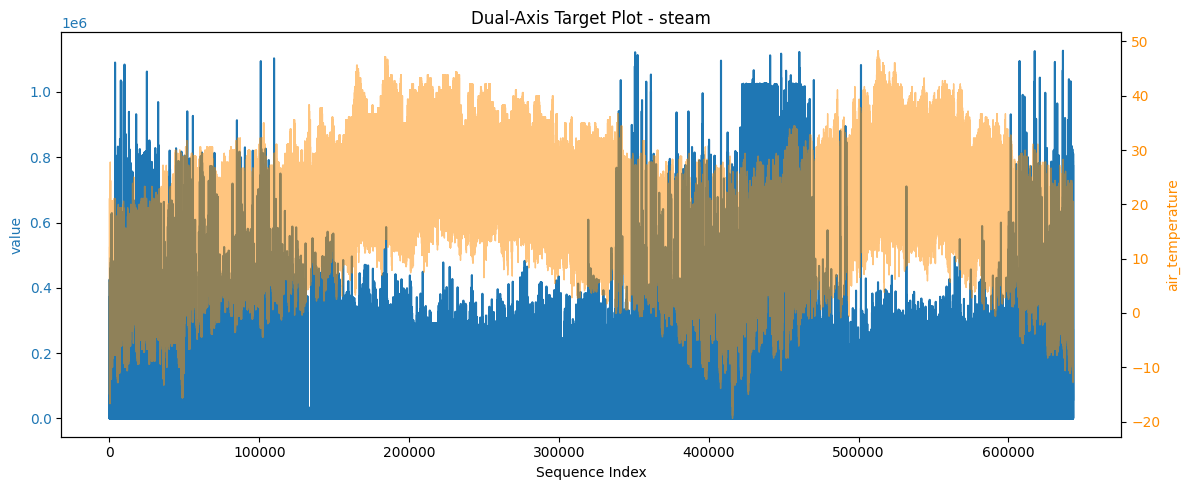

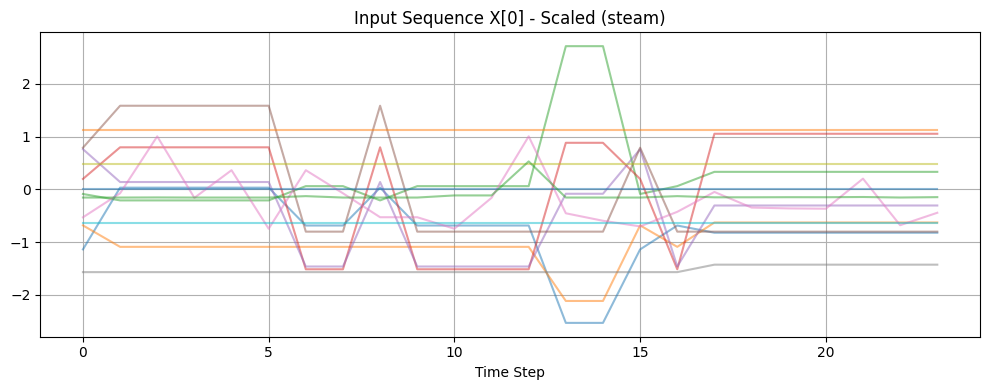

정규화된 y[0]: [-0.14603831 -0.82115084]
복원된 y[0] (value, air_temperature): [534.92474     5.6000004]

 시각화: hotwater


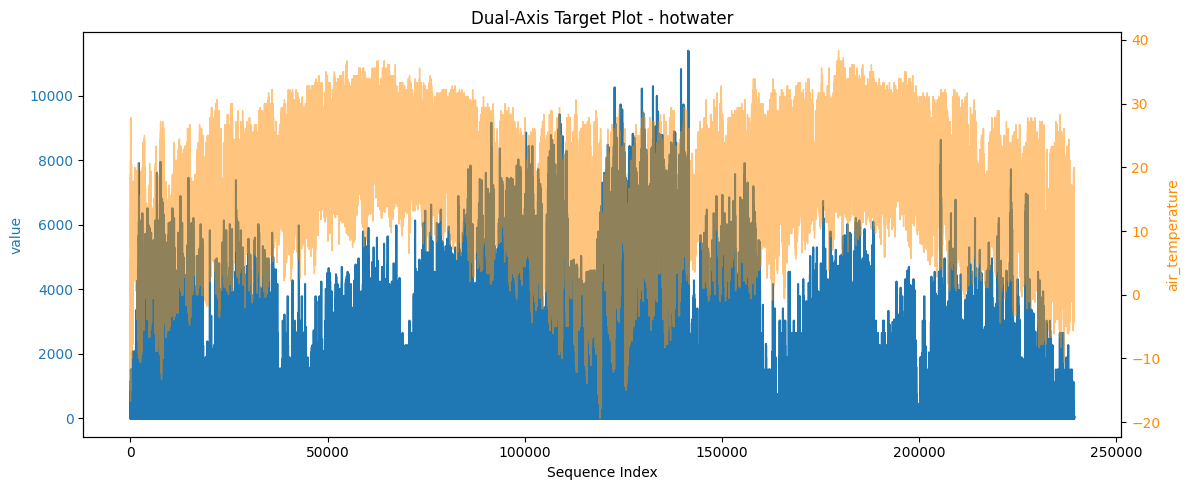

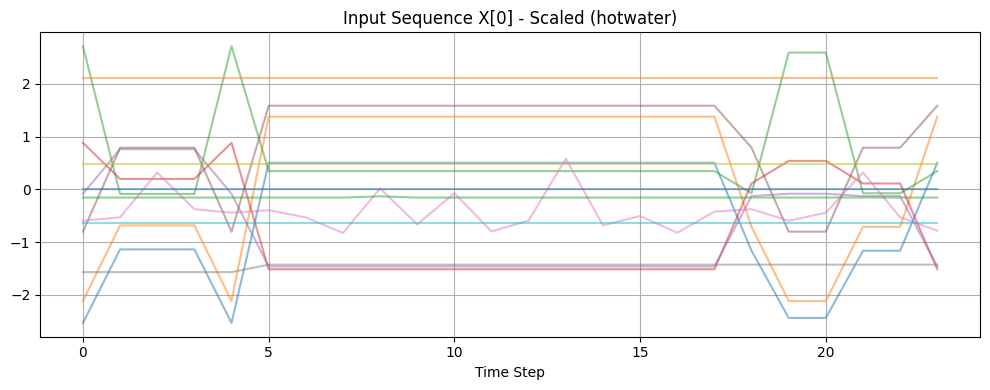

정규화된 y[0]: [-0.15440384  0.503005  ]
복원된 y[0] (value, air_temperature): [-4.69805e-05  2.11000e+01]

 시각화: gas


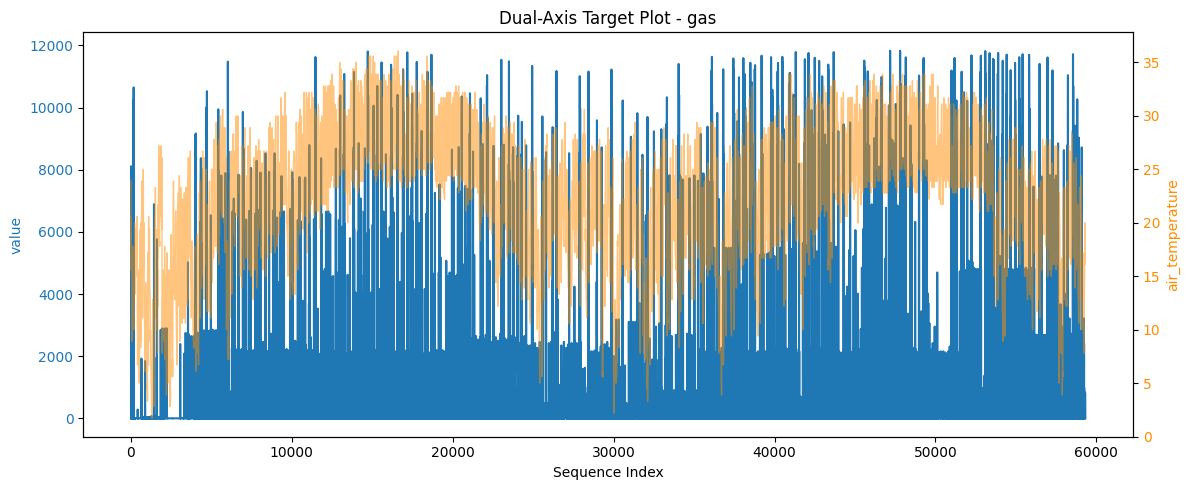

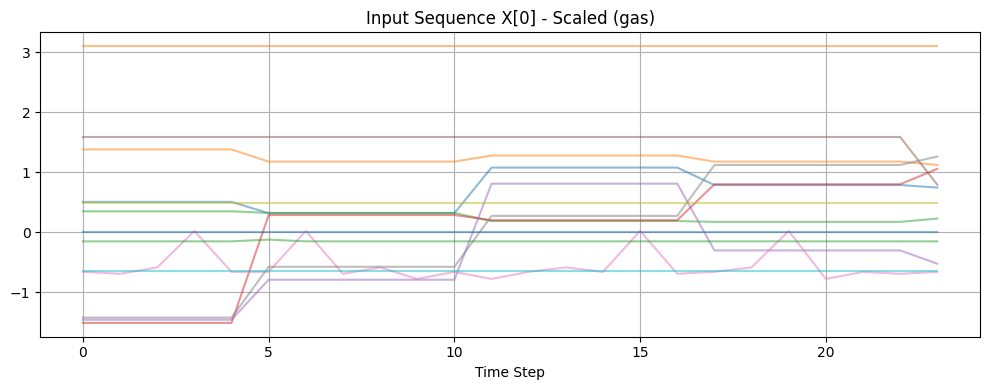

정규화된 y[0]: [-0.15440384  0.7422074 ]
복원된 y[0] (value, air_temperature): [-4.69805e-05  2.39000e+01]

 시각화: water
[!] water 데이터 없음, 건너뜀

 시각화: irrigation
[!] irrigation 데이터 없음, 건너뜀

 시각화: solar
[!] solar 데이터 없음, 건너뜀


In [24]:
scaler_y_path = SCALER_DIR / "scaler_y_all.pkl"
scaler_y = joblib.load(scaler_y_path)

for meter_type in meter_types:
    print(f"\n시각화: {meter_type}")

    # 파일 경로
    X_path = OUTPUT_DIR / f"X_lstm_{meter_type}.npy"
    y_path = OUTPUT_DIR / f"y_lstm_{meter_type}.npy"

    # 데이터 로딩
    if not X_path.exists() or not y_path.exists():
        print(f"{meter_type} 데이터 없음, 건너뜀")
        continue

    X = np.load(X_path)
    y_scaled = np.load(y_path)
    y = scaler_y.inverse_transform(y_scaled)

    # 이중 y축 시각화
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(y[:, 0], label="value", color='tab:blue')
    ax1.set_xlabel("Sequence Index")
    ax1.set_ylabel("value", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

  
    ax2 = ax1.twinx()
    ax2.plot(y[:, 1], label="air_temperature", color='darkorange', linewidth=1, alpha=0.5)
    ax2.set_ylabel("air_temperature", color='darkorange')
    ax2.tick_params(axis='y', labelcolor='darkorange')

    plt.title(f"Dual-Axis Target Plot - {meter_type}")
    plt.tight_layout()
    plt.show()

    # 샘플 시퀀스 1개 시각화
    idx = 0
    plt.figure(figsize=(10, 4))
    for i in range(X.shape[2]):
        plt.plot(X[idx, :, i], label=f"feat {i}" if i < 5 else None, alpha=0.5)
    plt.title(f"Input Sequence X[{idx}] - Scaled ({meter_type})")
    plt.xlabel("Time Step")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 타겟값 출력
    print("정규화된 y[0]:", y_scaled[0])
    print("복원된 y[0] (value, air_temperature):", y[0])


In [20]:
# # 문자열 → 숫자 ID 변환
# df["meter_type"] = df["meter_type"].map(meter_name_to_id)

# # 슬라이딩 윈도우 생성
# window_size = 24
# X_seq, y_seq = [], []

# for i in range(len(df) - window_size):
#    X_window = df[input_cols].iloc[i:i+window_size].values
#    y_target = df[target_cols].iloc[i+window_size].values
#    X_seq.append(X_window)
#    y_seq.append(y_target)

# X_seq = np.array(X_seq)
# y_seq = np.array(y_seq)
# print("X_seq shape:", X_seq.shape, "y_seq shape:", y_seq.shape)



In [21]:
# # 정규화
# scaler = StandardScaler()
# X_seq_flat = X_seq.reshape(-1, len(input_cols))
# X_seq_scaled = scaler.fit_transform(X_seq_flat).reshape(-1, window_size, len(input_cols))


In [22]:
# # 시각화
# plt.figure(figsize=(10, 4))
# for i in range(X_seq_scaled.shape[2]):
#    plt.plot(X_seq_scaled[0, :, i], alpha=0.6)

# # 정규화된 X의 기준으로 y[0][0] 값 비교 (value는 input에도 포함됨)
# value_index = input_cols.index("value")
# value_scaled = scaler.transform(np.array([X_seq[0, -1, :]]))[0, value_index]
# plt.axhline(y=value_scaled, color='red', linestyle='--', label='Target value (unscaled)')
# plt.title("Sample LSTM Sequence (X[0]) and Target (y[0])")
# plt.xlabel("Time step")
# plt.ylabel("Scaled Feature Value")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [23]:

# # 5. 저장
# OUTPUT_DIR = Path(OUTPUT_DIR)
# OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
# np.save(X_OUTPUT, X_seq_scaled)
# np.save(Y_OUTPUT, y_seq)

# SCALER_OUTPUT.parent.mkdir(parents=True, exist_ok=True)
# joblib.dump(scaler, SCALER_OUTPUT)

# print("Saved")
# print(f"X shape: {X_seq_scaled.shape}, y shape: {y_seq.shape}")
# print(f"Input cols: {input_cols}")
# print(f"Target cols: {target_cols}")
